# Heart Disease Prediction Model

Complete machine learning workflow for predicting HeartDisease (1/0) using various classification algorithms.

## Overview
This notebook implements a comprehensive ML pipeline including:
- Exploratory Data Analysis (EDA)
- Data Preprocessing and Feature Engineering
- Multiple Model Training and Evaluation
- Model Selection and Final Evaluation
- Model Explainability (SHAP)
- Model Artifact Saving


## ====================================================
## SECTION 1 — IMPORTS
## ====================================================


In [2]:
# Standard library imports
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Scikit-learn imports
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Imbalanced learning
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    print("Warning: imblearn not available. SMOTE will be skipped.")
    SMOTE_AVAILABLE = False

# XGBoost (optional)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("Warning: XGBoost not available. XGBoost model will be skipped.")
    XGBOOST_AVAILABLE = False

# LightGBM (optional)
try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("Warning: LightGBM not available. Install via `pip install lightgbm`.")
    LIGHTGBM_AVAILABLE = False

# SHAP for explainability (optional)
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("Warning: SHAP not available. SHAP analysis will be skipped.")
    SHAP_AVAILABLE = False

# Model persistence
import joblib
import os

print("✓ All imports completed successfully!")
print(f"SMOTE available: {SMOTE_AVAILABLE}")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
print(f"SHAP available: {SHAP_AVAILABLE}")


✓ All imports completed successfully!
SMOTE available: True
XGBoost available: True
LightGBM available: True
SHAP available: True


## ====================================================
## SECTION 2 — LOAD DATA
## ====================================================


In [3]:
# Define the dataset path
dataset_path = "/Volumes/Crucial X6/medical_ai_extra/Heart_Disease/heart (1).csv"

# Load the dataset
print("Loading dataset...")
df = pd.read_csv(dataset_path)

print(f"\n✓ Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst 10 rows:")
print(df.head(10))
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nData types:")
print(df.dtypes)


Loading dataset...

✓ Dataset loaded successfully!
Dataset shape: (918, 12)

First 10 rows:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   
5   39   M           NAP        120          339          0     Normal    170   
6   45   F           ATA        130          237          0     Normal    170   
7   54   M           ATA        110          208          0     Normal    142   
8   37   M           ASY        140          207          0     Normal    130   
9   48   F           ATA        120          284          0     Normal    120   

  ExerciseAngina

## ====================================================
## SECTION 3 — EDA (EXPLORATORY DATA ANALYSIS)
## ====================================================


In [4]:
# 3.1 Basic Information
print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)
df.info()


DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
# 3.2 Statistical Summary
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
print(df.describe())


In [5]:
# 3.3 Missing Values Check
print("=" * 60)
print("MISSING VALUES CHECK")
print("=" * 60)
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0]
if len(missing_df) > 0:
    print(missing_df)
else:
    print("✓ No missing values found!")


MISSING VALUES CHECK
✓ No missing values found!


In [6]:
# 3.4 Unique Values per Column
print("=" * 60)
print("UNIQUE VALUES PER COLUMN")
print("=" * 60)
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"  Values: {df[col].unique()}")
    print()


UNIQUE VALUES PER COLUMN
Age: 50 unique values

Sex: 2 unique values
  Values: ['M' 'F']

ChestPainType: 4 unique values
  Values: ['ATA' 'NAP' 'ASY' 'TA']

RestingBP: 67 unique values

Cholesterol: 222 unique values

FastingBS: 2 unique values
  Values: [0 1]

RestingECG: 3 unique values
  Values: ['Normal' 'ST' 'LVH']

MaxHR: 119 unique values

ExerciseAngina: 2 unique values
  Values: ['N' 'Y']

Oldpeak: 53 unique values

ST_Slope: 3 unique values
  Values: ['Up' 'Flat' 'Down']

HeartDisease: 2 unique values
  Values: [0 1]



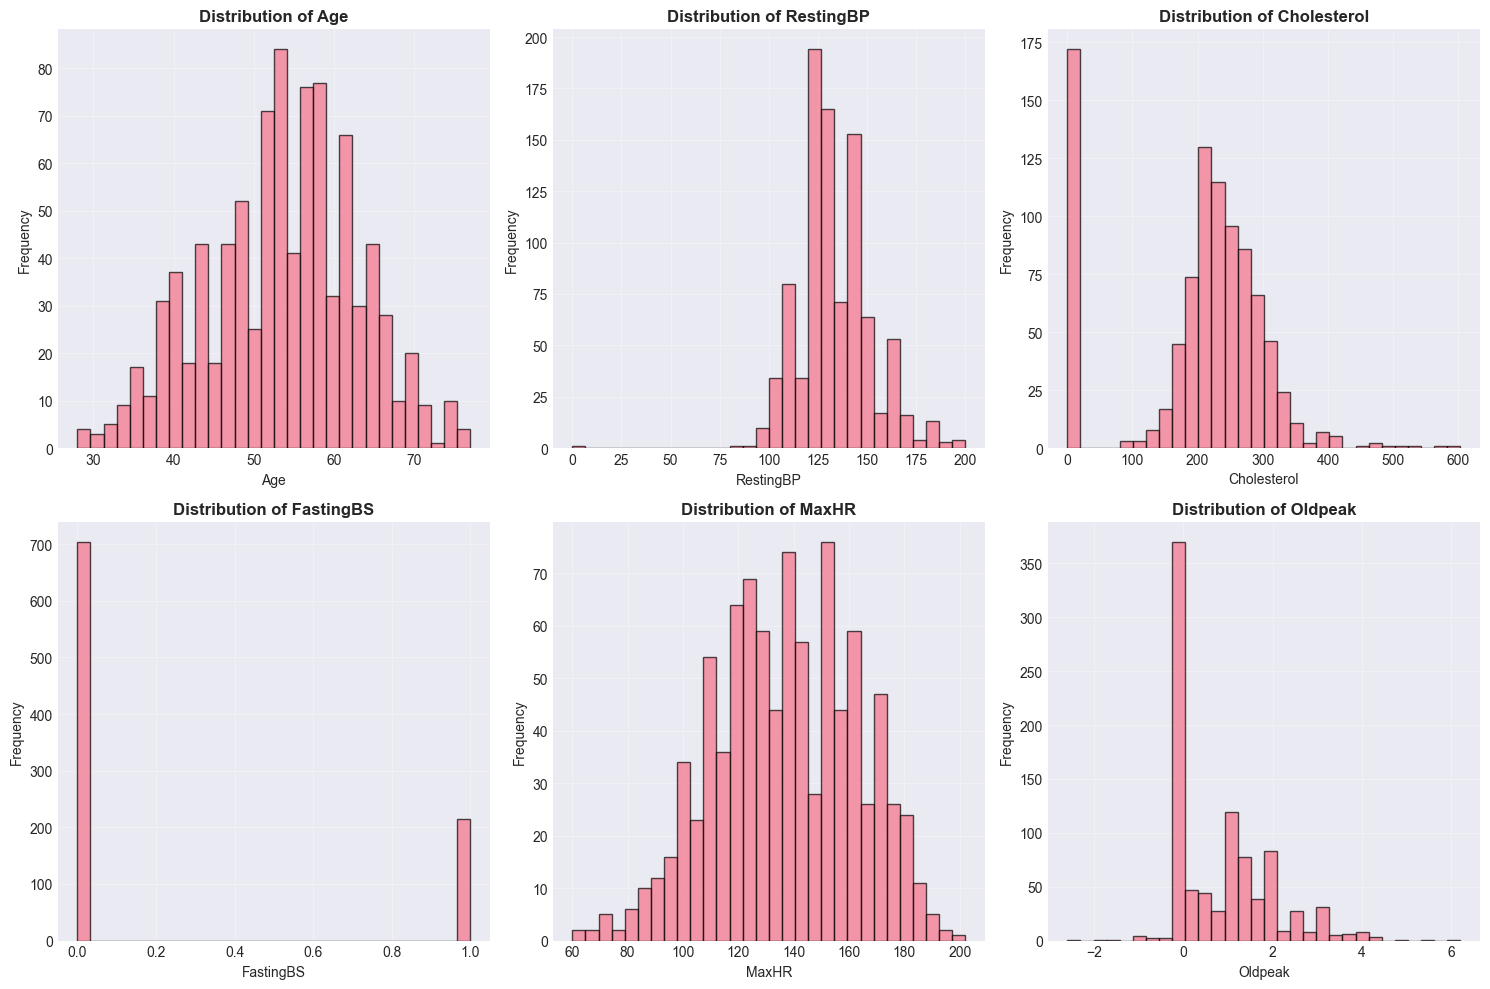

✓ Numerical distribution plots created


In [7]:
# 3.5 Distribution Plots for Numerical Variables
# Identify numerical columns (exclude target if it's binary)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'HeartDisease' in numerical_cols:
    numerical_cols.remove('HeartDisease')

n_numerical = len(numerical_cols)
n_cols = 3
n_rows = (n_numerical + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_numerical > 1 else [axes]

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_numerical, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()
print("✓ Numerical distribution plots created")


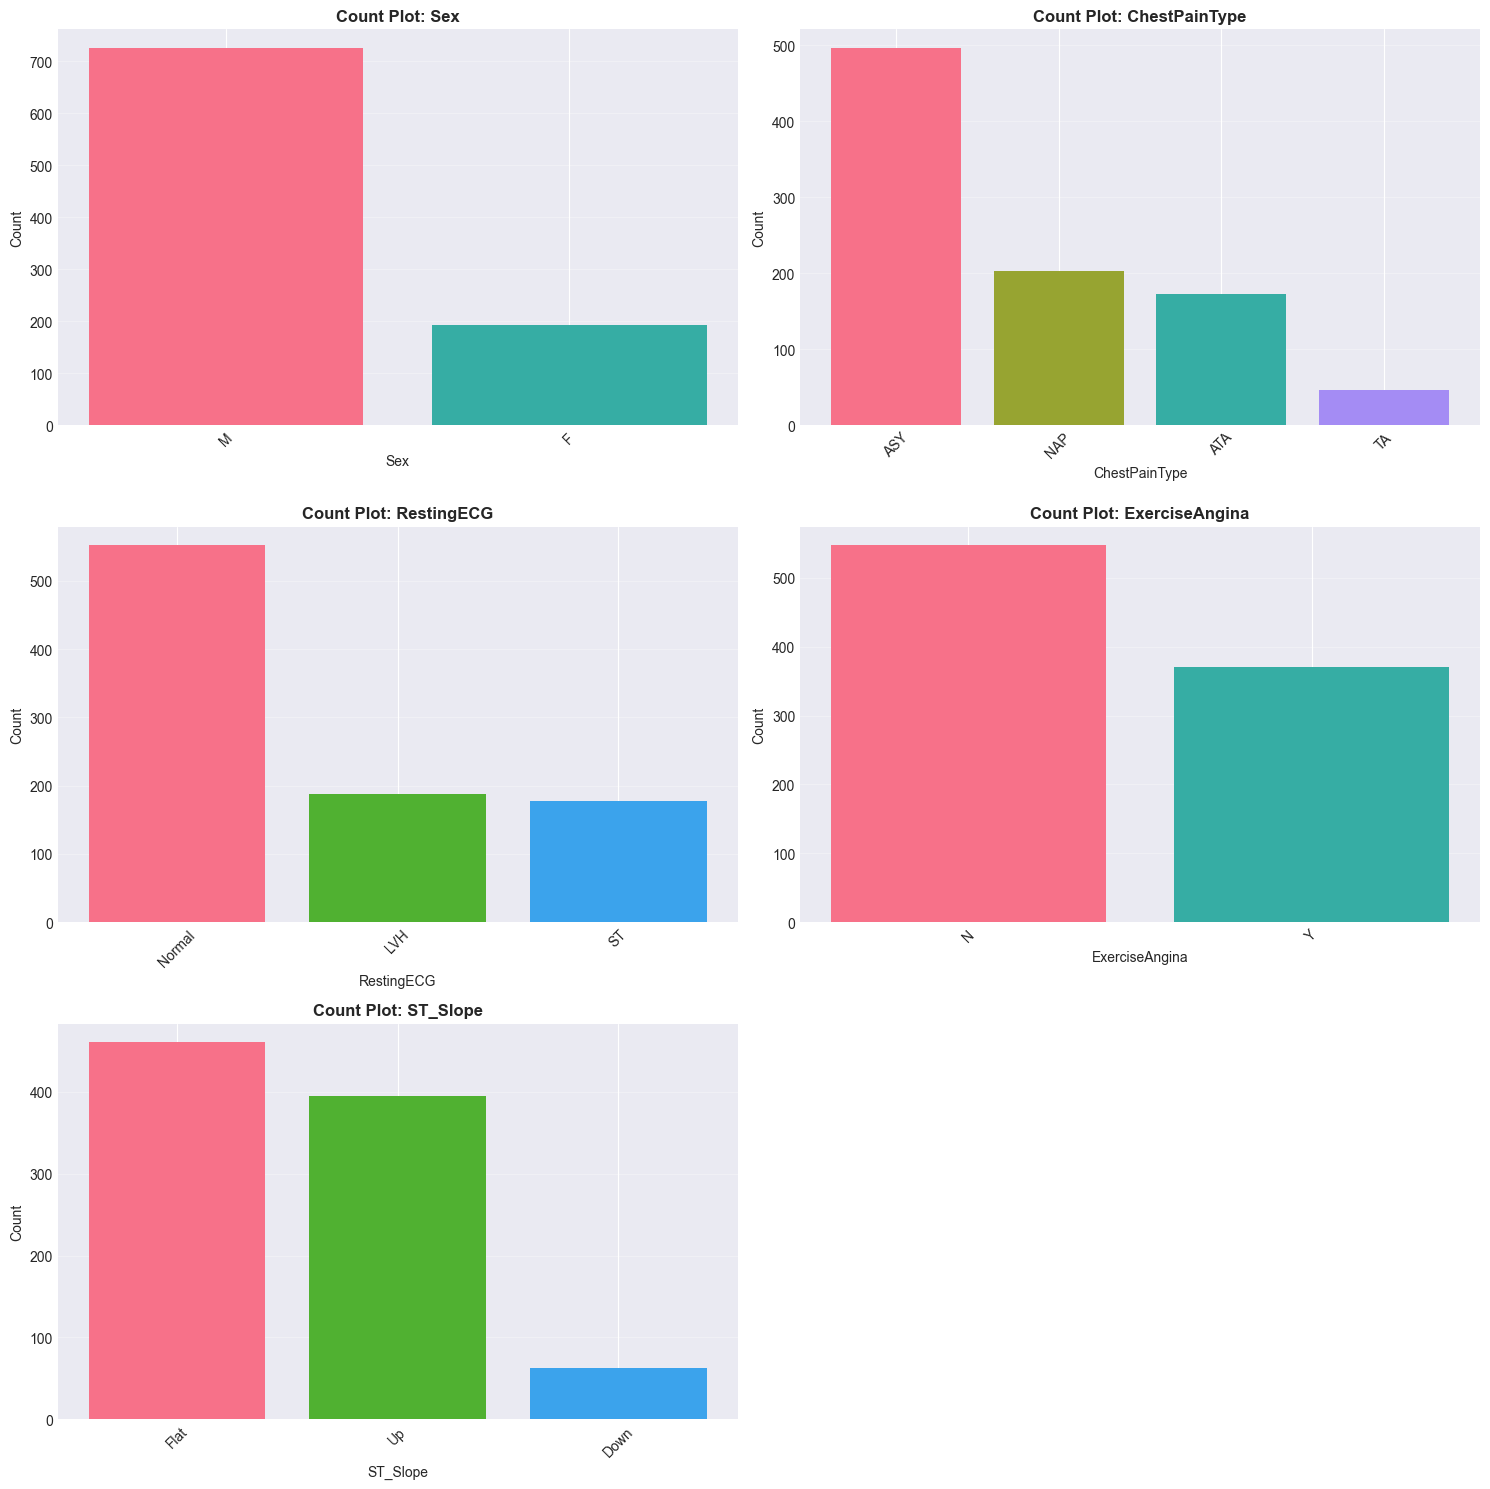

✓ Categorical count plots created


In [8]:
# 3.6 Count Plots for Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    n_categorical = len(categorical_cols)
    n_cols = 2
    n_rows = (n_categorical + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_categorical > 1 else [axes]
    
    for idx, col in enumerate(categorical_cols):
        value_counts = df[col].value_counts()
        axes[idx].bar(value_counts.index.astype(str), value_counts.values, 
                     color=sns.color_palette("husl", len(value_counts)))
        axes[idx].set_title(f'Count Plot: {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Hide extra subplots
    for idx in range(n_categorical, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("✓ Categorical count plots created")
else:
    print("No categorical variables found (all are numerical or already encoded)")


HEART DISEASE CLASS DISTRIBUTION
Class 0 (No Heart Disease): 410 (44.66%)
Class 1 (Heart Disease): 508 (55.34%)


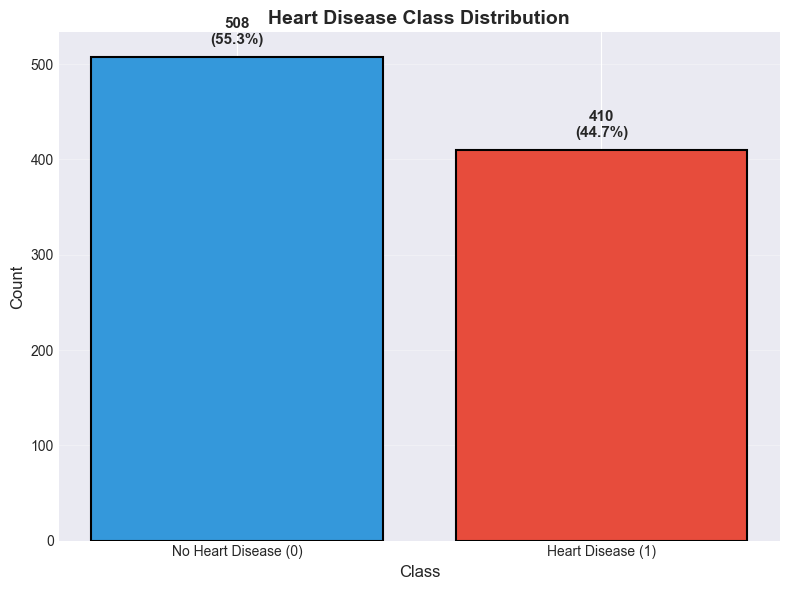

✓ Class balance plot created


In [9]:
# 3.7 HeartDisease Class Balance Bar Plot
print("=" * 60)
print("HEART DISEASE CLASS DISTRIBUTION")
print("=" * 60)
class_counts = df['HeartDisease'].value_counts()
class_percentages = df['HeartDisease'].value_counts(normalize=True) * 100

print(f"Class 0 (No Heart Disease): {class_counts[0]} ({class_percentages[0]:.2f}%)")
print(f"Class 1 (Heart Disease): {class_counts[1]} ({class_percentages[1]:.2f}%)")

plt.figure(figsize=(8, 6))
bars = plt.bar(['No Heart Disease (0)', 'Heart Disease (1)'], 
               class_counts.values, 
               color=['#3498db', '#e74c3c'], 
               edgecolor='black', linewidth=1.5)
plt.title('Heart Disease Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for bar, count, pct in zip(bars, class_counts.values, class_percentages.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{count}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()
print("✓ Class balance plot created")


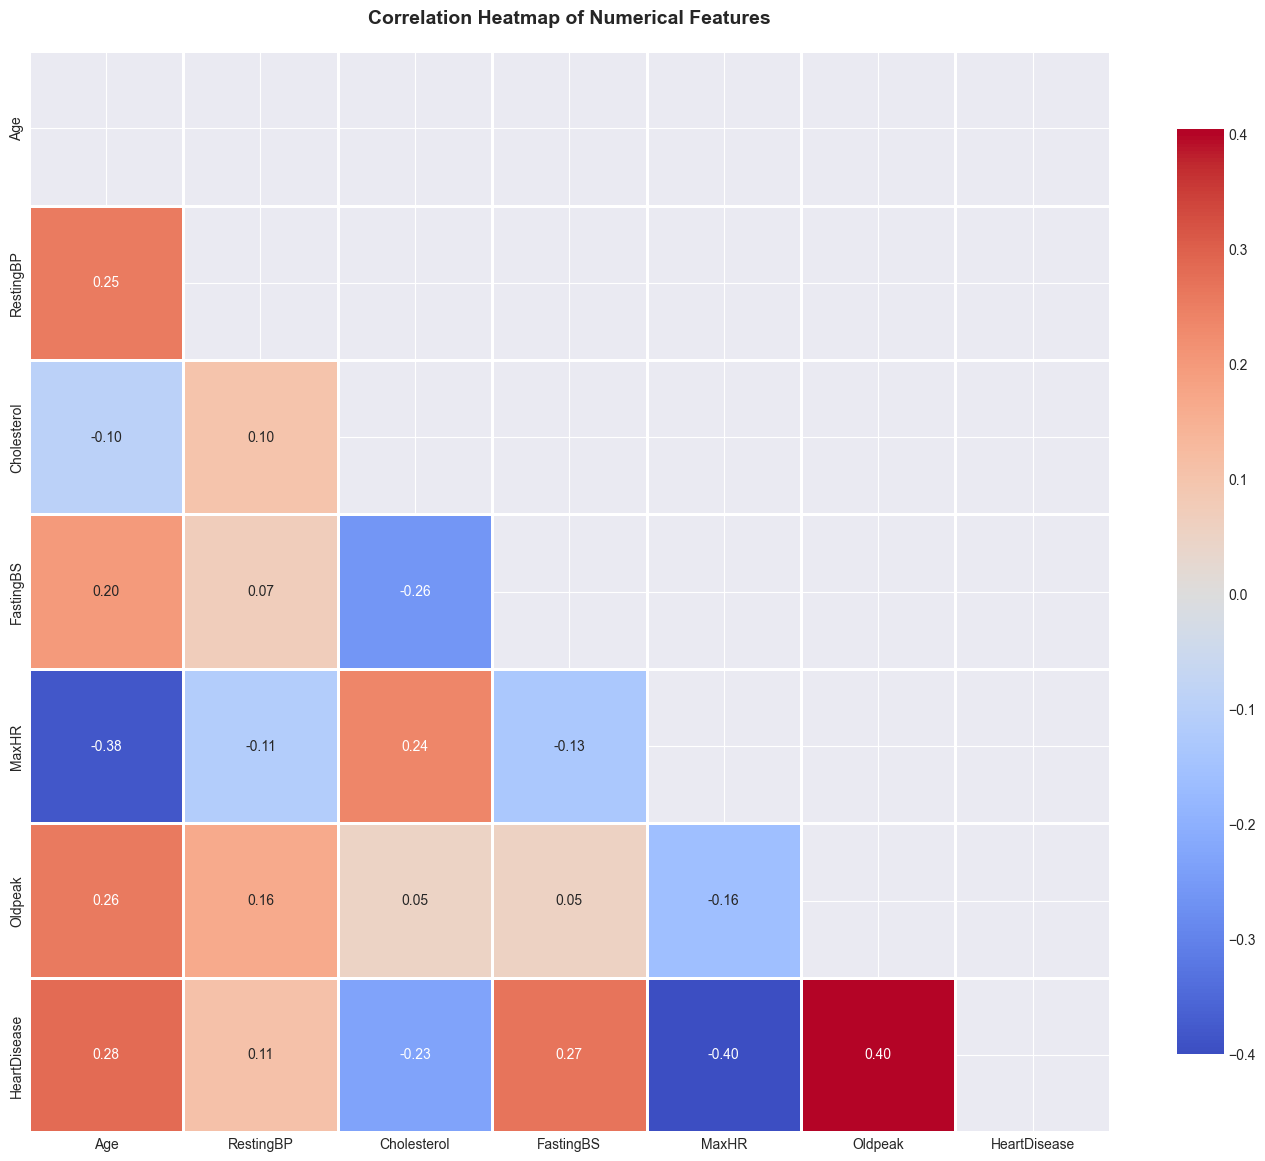


Correlation with HeartDisease:
Oldpeak        0.403951
Age            0.282039
FastingBS      0.267291
RestingBP      0.107589
Cholesterol   -0.232741
MaxHR         -0.400421
Name: HeartDisease, dtype: float64

✓ Correlation heatmap created


In [10]:
# 3.8 Correlation Heatmap
# Calculate correlation matrix for numerical features
numerical_df = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8},
            mask=mask)
plt.title('Correlation Heatmap of Numerical Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print correlation with target
if 'HeartDisease' in correlation_matrix.columns:
    print("\nCorrelation with HeartDisease:")
    target_corr = correlation_matrix['HeartDisease'].drop('HeartDisease').sort_values(ascending=False)
    print(target_corr)
print("\n✓ Correlation heatmap created")


## ====================================================
## SECTION 4 — PREPROCESSING
## ====================================================


In [11]:
print("=" * 60)
print("PREPROCESSING STEP 1: FEATURE ENGINEERING & DATASET PREP")
print("=" * 60)

TARGET_COL = 'HeartDisease'

# ---- High-impact engineered features ----
def add_engineered_features(df_input: pd.DataFrame) -> pd.DataFrame:
    df_fe = df_input.copy()

    # Age buckets (risk bands)
    age_bucket = pd.cut(
        df_fe['Age'],
        bins=[0, 40, 55, 120],
        labels=['young', 'middle', 'old']
    )
    df_fe['age_bucket'] = age_bucket.cat.add_categories(['unknown']).fillna('unknown')

    # Cholesterol categories
    chol_bucket = pd.cut(
        df_fe['Cholesterol'],
        bins=[0, 200, 240, 600],
        labels=['normal', 'borderline', 'high']
    )
    df_fe['chol_cat'] = chol_bucket.cat.add_categories(['unknown']).fillna('unknown')

    # Binary risk indicators
    df_fe['bp_high'] = (df_fe['RestingBP'] > 130).astype(int)
    df_fe['oldpeak_flag'] = (df_fe['Oldpeak'] > 1).astype(int)

    # Heart rate to age ratio
    age_safe = df_fe['Age'].replace(0, np.nan)
    hr_ratio = df_fe['MaxHR'] / age_safe
    df_fe['hr_ratio'] = hr_ratio.fillna(hr_ratio.median())

    return df_fe

# Apply feature engineering
print("Adding engineered features (age_bucket, chol_cat, bp_high, hr_ratio, oldpeak_flag)...")
df_fe = add_engineered_features(df)

# Separate features/target
X = df_fe.drop(columns=[TARGET_COL])
y = df_fe[TARGET_COL]

print(f"Dataset with engineered features shape: {df_fe.shape}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")


PREPROCESSING STEP 1: FEATURE ENGINEERING & DATASET PREP
Adding engineered features (age_bucket, chol_cat, bp_high, hr_ratio, oldpeak_flag)...
Dataset with engineered features shape: (918, 17)
Feature matrix shape: (918, 16)
Target distribution: {1: 508, 0: 410}


In [12]:
print("\n" + "=" * 60)
print("PREPROCESSING STEP 2: FEATURE TYPE IDENTIFICATION")
print("=" * 60)

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Total engineered features: {len(categorical_features) + len(numeric_features)}")



PREPROCESSING STEP 2: FEATURE TYPE IDENTIFICATION
Categorical features (7): ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'age_bucket', 'chol_cat']
Numeric features (9): ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'bp_high', 'oldpeak_flag', 'hr_ratio']
Total engineered features: 16


In [13]:
print("\n" + "=" * 60)
print("PREPROCESSING STEP 3: TRAIN/TEST SPLIT + CV SETUP")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("Training target distribution:")
print(y_train.value_counts())
print("Test target distribution:")
print(y_test.value_counts())

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nStratifiedKFold configured with 5 splits, shuffle=True, random_state=42")



PREPROCESSING STEP 3: TRAIN/TEST SPLIT + CV SETUP
Training set shape: (734, 16)
Test set shape: (184, 16)
Training target distribution:
HeartDisease
1    406
0    328
Name: count, dtype: int64
Test target distribution:
HeartDisease
1    102
0     82
Name: count, dtype: int64

StratifiedKFold configured with 5 splits, shuffle=True, random_state=42


In [15]:
print("\n" + "=" * 60)
print("PREPROCESSING STEP 4: BUILD COLUMNTRANSFORMER PIPELINE")
print("=" * 60)

numeric_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
categorical_pipeline = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
)

def build_preprocessor() -> ColumnTransformer:
    return ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('cat', categorical_pipeline, categorical_features)
        ]
    )

print("ColumnTransformer configured with StandardScaler for numeric features and OneHotEncoder for categoricals.")
print("handle_unknown='ignore' guards against unseen categories during evaluation/deployment.")



PREPROCESSING STEP 4: BUILD COLUMNTRANSFORMER PIPELINE
ColumnTransformer configured with StandardScaler for numeric features and OneHotEncoder for categoricals.
handle_unknown='ignore' guards against unseen categories during evaluation/deployment.


In [16]:
print("\n" + "=" * 60)
print("PREPROCESSING STEP 5: PIPELINE FACTORY")
print("=" * 60)

def build_model_pipeline(estimator) -> Pipeline:
    return Pipeline(
        steps=[
            ('preprocess', build_preprocessor()),
            ('classifier', estimator)
        ]
    )

print("All downstream models will be wrapped in Pipeline(preprocess -> estimator) to eliminate data leakage.")



PREPROCESSING STEP 5: PIPELINE FACTORY
All downstream models will be wrapped in Pipeline(preprocess -> estimator) to eliminate data leakage.


In [17]:
print("\n" + "=" * 60)
print("PREPROCESSING STEP 6: STRATIFIED K-FOLD EVALUATION STRATEGY")
print("=" * 60)

print("Class balance will be maintained inside each fold via StratifiedKFold.")
print("This avoids synthetic sampling and keeps evaluation close to the real distribution.")
print("All cross-validation metrics in the next section will use this splitter.")



PREPROCESSING STEP 6: STRATIFIED K-FOLD EVALUATION STRATEGY
Class balance will be maintained inside each fold via StratifiedKFold.
This avoids synthetic sampling and keeps evaluation close to the real distribution.
All cross-validation metrics in the next section will use this splitter.


## ====================================================
## SECTION 5 — MODEL TRAINING
## ====================================================


In [18]:
print("=" * 60)
print("ADVANCED MODELING WITH PIPELINES + STRATIFIED CV")
print("=" * 60)

model_pipelines = {}
cv_metrics_summary = []


ADVANCED MODELING WITH PIPELINES + STRATIFIED CV


In [20]:
# 5.1 Tuned Random Forest via RandomizedSearchCV
print("\n" + "-" * 60)
print("MODEL 1: RANDOM FOREST (TUNED)")
print("-" * 60)

rf_base_pipeline = build_model_pipeline(
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

rf_param_distributions = {
    'classifier__n_estimators': [300, 600, 900, 1200],
    'classifier__max_depth': [4, 6, 8, 12, 16, None],
    'classifier__min_samples_split': [2, 4, 6, 10],
    'classifier__min_samples_leaf': [1, 2, 3, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(
    estimator=rf_base_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=30,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

rf_random_search.fit(X_train, y_train)
best_rf_pipeline = rf_random_search.best_estimator_
print(f"Best ROC-AUC (CV mean): {rf_random_search.best_score_:.4f}")
print("Best hyperparameters:")
for param, value in rf_random_search.best_params_.items():
    print(f"  {param}: {value}")

model_pipelines['Random Forest (Tuned)'] = best_rf_pipeline



------------------------------------------------------------
MODEL 1: RANDOM FOREST (TUNED)
------------------------------------------------------------
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=1200; total time=  12.2s
[CV] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=1200; total time=  12.6s
[CV] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=1200; total time=  12.8s
[CV] END classifier__bootstrap=False, classifier__max_depth=12, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_spl

In [21]:
# 5.2 Additional pipeline-based models
print("\n" + "-" * 60)
print("ADDING OTHER MODEL PIPELINES")
print("-" * 60)

log_reg_pipeline = build_model_pipeline(
    LogisticRegression(random_state=42, max_iter=1000)
)
model_pipelines['Logistic Regression'] = log_reg_pipeline
print("✓ Logistic Regression pipeline ready")

if XGBOOST_AVAILABLE:
    xgb_pipeline = build_model_pipeline(
        xgb.XGBClassifier(
            random_state=42,
            n_estimators=400,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric='logloss',
            n_jobs=-1,
            use_label_encoder=False
        )
    )
    model_pipelines['XGBoost'] = xgb_pipeline
    print("✓ XGBoost pipeline ready")
else:
    print("⚠️ XGBoost not available; skipping its pipeline")

if LIGHTGBM_AVAILABLE:
    lgbm_pipeline = build_model_pipeline(
        LGBMClassifier(
            random_state=42,
            n_estimators=400,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8
        )
    )
    model_pipelines['LightGBM'] = lgbm_pipeline
    print("✓ LightGBM pipeline ready")
else:
    print("⚠️ LightGBM not available; install lightgbm to enable it")



------------------------------------------------------------
ADDING OTHER MODEL PIPELINES
------------------------------------------------------------
✓ Logistic Regression pipeline ready
✓ XGBoost pipeline ready
✓ LightGBM pipeline ready


In [22]:
# 5.3 Stratified CV evaluation for all models
print("\n" + "-" * 60)
print("STRATIFIED 5-FOLD CROSS-VALIDATION RESULTS")
print("-" * 60)

scoring_metrics = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'accuracy': 'accuracy'
}

cv_raw_scores = {}
cv_metrics_summary = []

for model_name, pipeline in model_pipelines.items():
    print(f"\nEvaluating {model_name}...")
    metric_stats = {}
    for metric_key, scoring in scoring_metrics.items():
        scores = cross_val_score(
            pipeline,
            X_train,
            y_train,
            cv=skf,
            scoring=scoring,
            n_jobs=-1
        )
        metric_stats[metric_key] = scores
        print(f"  {metric_key.upper()} -> mean {scores.mean():.4f} ± {scores.std():.4f}")
    cv_raw_scores[model_name] = metric_stats
    cv_metrics_summary.append({
        'Model': model_name,
        'ROC-AUC Mean': metric_stats['roc_auc'].mean(),
        'ROC-AUC Std': metric_stats['roc_auc'].std(),
        'F1 Mean': metric_stats['f1'].mean(),
        'F1 Std': metric_stats['f1'].std(),
        'Accuracy Mean': metric_stats['accuracy'].mean(),
        'Accuracy Std': metric_stats['accuracy'].std()
    })

cv_metrics_df = pd.DataFrame(cv_metrics_summary).sort_values('ROC-AUC Mean', ascending=False)
cv_metrics_df



------------------------------------------------------------
STRATIFIED 5-FOLD CROSS-VALIDATION RESULTS
------------------------------------------------------------

Evaluating Random Forest (Tuned)...
  ROC_AUC -> mean 0.9340 ± 0.0271
  F1 -> mean 0.8877 ± 0.0337
  ACCURACY -> mean 0.8706 ± 0.0421

Evaluating Logistic Regression...
  ROC_AUC -> mean 0.9278 ± 0.0378
  F1 -> mean 0.8772 ± 0.0312
  ACCURACY -> mean 0.8611 ± 0.0390

Evaluating XGBoost...
  ROC_AUC -> mean 0.9229 ± 0.0263
  F1 -> mean 0.8749 ± 0.0177
  ACCURACY -> mean 0.8597 ± 0.0205

Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 324, number of negative: 263[LightGBM] [Info] Number of positive: 325, number of negative: 262

[LightGBM] [Info] Number of positive: 325, number of negative: 262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

,Model,ROC-AUC Mean,ROC-AUC Std,F1 Mean,F1 Std,Accuracy Mean,Accuracy Std
0,Random Forest (Tuned),0.934007,0.027084,0.887742,0.033681,0.870599,0.042084
1,Logistic Regression,0.927754,0.037772,0.877184,0.031242,0.861075,0.038989
2,XGBoost,0.922945,0.026321,0.874881,0.017749,0.859668,0.020483
3,LightGBM,0.921104,0.026207,0.870644,0.023454,0.854235,0.028995


In [23]:
# 5.4 Comparison table (mean ± std)
print("\n" + "=" * 60)
print("CROSS-VALIDATION METRICS SUMMARY")
print("=" * 60)

comparison_df = cv_metrics_df.copy()
comparison_df['ROC-AUC (mean±std)'] = comparison_df.apply(
    lambda row: f"{row['ROC-AUC Mean']:.4f} ± {row['ROC-AUC Std']:.4f}", axis=1
)
comparison_df['F1 (mean±std)'] = comparison_df.apply(
    lambda row: f"{row['F1 Mean']:.4f} ± {row['F1 Std']:.4f}", axis=1
)
comparison_df['Accuracy (mean±std)'] = comparison_df.apply(
    lambda row: f"{row['Accuracy Mean']:.4f} ± {row['Accuracy Std']:.4f}", axis=1
)

columns_to_display = [
    'Model',
    'ROC-AUC (mean±std)',
    'F1 (mean±std)',
    'Accuracy (mean±std)'
]

print(comparison_df[columns_to_display].to_string(index=False))
print("\n✓ Stratified CV comparison completed")



CROSS-VALIDATION METRICS SUMMARY
                Model ROC-AUC (mean±std)   F1 (mean±std) Accuracy (mean±std)
Random Forest (Tuned)    0.9340 ± 0.0271 0.8877 ± 0.0337     0.8706 ± 0.0421
  Logistic Regression    0.9278 ± 0.0378 0.8772 ± 0.0312     0.8611 ± 0.0390
              XGBoost    0.9229 ± 0.0263 0.8749 ± 0.0177     0.8597 ± 0.0205
             LightGBM    0.9211 ± 0.0262 0.8706 ± 0.0235     0.8542 ± 0.0290

✓ Stratified CV comparison completed


In [24]:
# 5.5 Fit pipelines on full training data and pick best via CV ROC-AUC
print("\n" + "=" * 60)
print("FIT MODELS + SELECT BEST PIPELINE")
print("=" * 60)

trained_models = {}
for model_name, pipeline in model_pipelines.items():
    print(f"Fitting {model_name} on training data...")
    trained_models[model_name] = pipeline.fit(X_train, y_train)

best_model_name = comparison_df.iloc[0]['Model']
best_model_pipeline = trained_models[best_model_name]
print(f"\nBest model based on CV ROC-AUC: {best_model_name}")
print("We'll use this pipeline for hold-out testing and explainability.")



FIT MODELS + SELECT BEST PIPELINE
Fitting Random Forest (Tuned) on training data...
Fitting Logistic Regression on training data...
Fitting XGBoost on training data...
Fitting LightGBM on training data...
[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Info] Start training from score 0.213340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

## ====================================================
## SECTION 6 — BEST MODEL SELECTION
## ====================================================


In [25]:
# 6.1 Best model summary from cross-validation
print("=" * 60)
print("BEST MODEL SELECTION (CV ROC-AUC)")
print("=" * 60)

best_row = comparison_df.iloc[0]
print(f"Best model: {best_model_name}")
print(f"ROC-AUC (mean±std): {best_row['ROC-AUC (mean±std)']}")
print(f"F1 (mean±std): {best_row['F1 (mean±std)']}")
print(f"Accuracy (mean±std): {best_row['Accuracy (mean±std)']}")

print("\nFull ranking by ROC-AUC:")
print(comparison_df[['Model', 'ROC-AUC (mean±std)']].to_string(index=False))


BEST MODEL SELECTION (CV ROC-AUC)
Best model: Random Forest (Tuned)
ROC-AUC (mean±std): 0.9340 ± 0.0271
F1 (mean±std): 0.8877 ± 0.0337
Accuracy (mean±std): 0.8706 ± 0.0421

Full ranking by ROC-AUC:
                Model ROC-AUC (mean±std)
Random Forest (Tuned)    0.9340 ± 0.0271
  Logistic Regression    0.9278 ± 0.0378
              XGBoost    0.9229 ± 0.0263
             LightGBM    0.9211 ± 0.0262


In [26]:
# 6.2 Hold-out test evaluation
print("\n" + "=" * 60)
print("EVALUATION ON HELD-OUT TEST SET")
print("=" * 60)

y_test_pred = best_model_pipeline.predict(X_test)
y_test_proba = best_model_pipeline.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")



EVALUATION ON HELD-OUT TEST SET
Accuracy: 0.8967
Precision: 0.8879
Recall: 0.9314
F1 Score: 0.9091
ROC-AUC: 0.9353


In [31]:
# 6.4 Simulated single-patient inference (commercial-style check)
print("\n" + "=" * 60)
print("SINGLE SAMPLE PREDICTION DEMO")
print("=" * 60)

threshold = 0.5  # business rule for flagging heart disease risk
sample_row = X_test.sample(1, random_state=7)
sample_truth = y_test.loc[sample_row.index].iloc[0]

proba_positive = best_model_pipeline.predict_proba(sample_row)[0, 1]
pred_label = int(proba_positive >= threshold)

print("Sample features:")
print(sample_row.to_dict(orient='records')[0])
print(f"\nActual HeartDisease label: {sample_truth}")
print(f"Predicted probability (HeartDisease=1): {proba_positive:.3f}")
print(f"Decision threshold: {threshold:.2f}")
print(f"Predicted class: {pred_label} -> {'Heart disease' if pred_label == 1 else 'No heart disease'}")
print(f"Result summary: TRUE={sample_truth} | PRED={pred_label}")




SINGLE SAMPLE PREDICTION DEMO
Sample features:
{'Age': 59, 'Sex': 'M', 'ChestPainType': 'ASY', 'RestingBP': 110, 'Cholesterol': 239, 'FastingBS': 0, 'RestingECG': 'LVH', 'MaxHR': 142, 'ExerciseAngina': 'Y', 'Oldpeak': 1.2, 'ST_Slope': 'Flat', 'age_bucket': 'old', 'chol_cat': 'borderline', 'bp_high': 0, 'oldpeak_flag': 1, 'hr_ratio': 2.406779661016949}

Actual HeartDisease label: 1
Predicted probability (HeartDisease=1): 0.833
Decision threshold: 0.50
Predicted class: 1 -> Heart disease
Result summary: TRUE=1 | PRED=1



ROC CURVE — BEST MODEL VS TEST SET


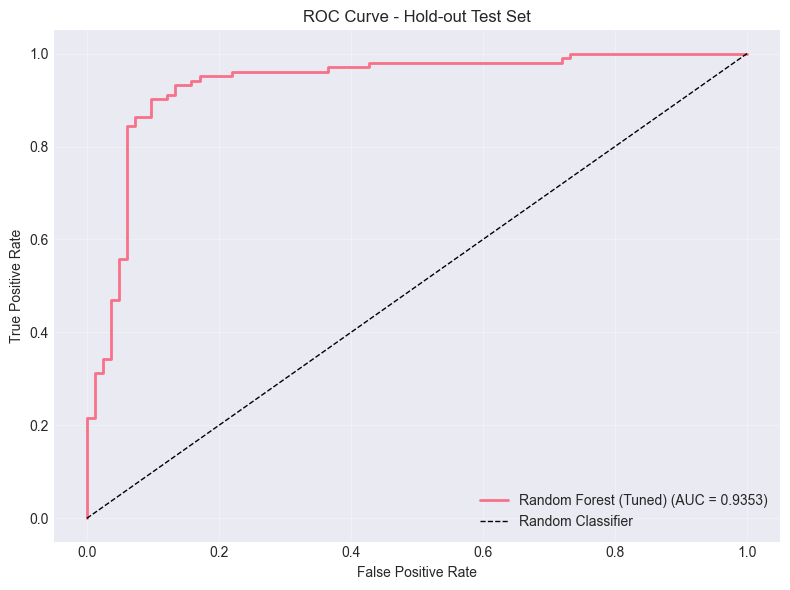

✓ ROC curve plotted for the best model


In [27]:
# 6.3 ROC curve for the best pipeline on the test set
print("\n" + "=" * 60)
print("ROC CURVE — BEST MODEL VS TEST SET")
print("=" * 60)

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {test_roc_auc:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Hold-out Test Set')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("✓ ROC curve plotted for the best model")



------------------------------------------------------------
CONFUSION MATRIX
------------------------------------------------------------

Confusion Matrix:
[[70 12]
 [ 7 95]]


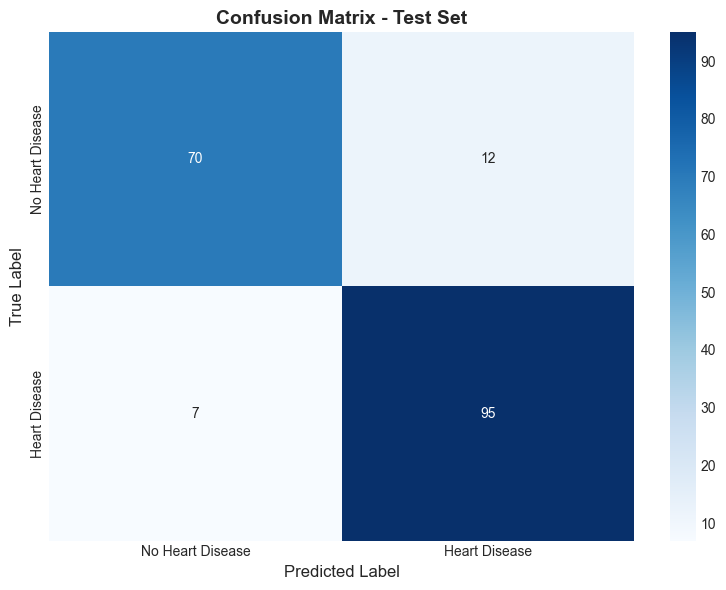


✓ Confusion matrix created


In [28]:
# 6.4 Confusion Matrix
print("\n" + "-" * 60)
print("CONFUSION MATRIX")
print("-" * 60)

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Confusion matrix created")


In [29]:
# 6.5 Full Classification Report
print("\n" + "-" * 60)
print("CLASSIFICATION REPORT")
print("-" * 60)

print("\n" + classification_report(y_test, y_test_pred, 
                                   target_names=['No Heart Disease', 'Heart Disease']))
print("✓ Classification report generated")



------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------

                  precision    recall  f1-score   support

No Heart Disease       0.91      0.85      0.88        82
   Heart Disease       0.89      0.93      0.91       102

        accuracy                           0.90       184
       macro avg       0.90      0.89      0.89       184
    weighted avg       0.90      0.90      0.90       184

✓ Classification report generated


## ====================================================
## SECTION 7 — EXPLAINABILITY
## ====================================================


In [ ]:
# 7.1 Feature Importances (Best Pipeline)
print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

preprocessor = best_model_pipeline.named_steps['preprocess']
classifier = best_model_pipeline.named_steps['classifier']

try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    feature_names = [f'feature_{i}' for i in range(preprocessor.transform(X_train.iloc[[0]]).shape[1])]

if hasattr(classifier, 'feature_importances_'):
    importances = classifier.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    print(f"Best model ({best_model_name}) feature importances — top 10:")
    print(importance_df.head(10).to_string(index=False))

    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'].values)
    plt.xlabel('Importance')
    plt.title(f'{best_model_name} - Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    print("\n✓ Feature importance analysis completed")
elif hasattr(classifier, 'coef_'):
    coefs = classifier.coef_[0]
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(coefs),
        'Coefficient': coefs
    }).sort_values('Importance', ascending=False)
    print(f"Best model ({best_model_name}) coefficient magnitudes — top 10:")
    print(importance_df.head(10).to_string(index=False))
else:
    print(f"Classifier {best_model_name} does not expose feature_importances_ or coefficients.")


In [ ]:
# 7.2 SHAP Values Analysis (if available)
if SHAP_AVAILABLE:
    print("\n" + "=" * 60)
    print("SHAP VALUES ANALYSIS")
    print("=" * 60)

    tree_based = hasattr(classifier, 'feature_importances_') or any(
        keyword in best_model_name.lower() for keyword in ['xgboost', 'lightgbm', 'forest']
    )

    sample_size = min(100, len(X_test))
    X_test_sample = X_test.iloc[:sample_size]
    X_test_sample_processed = preprocessor.transform(X_test_sample)
    feature_names = preprocessor.get_feature_names_out()

    if tree_based:
        print(f"Creating TreeExplainer for {best_model_name}...")
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_test_sample_processed)
    else:
        print(f"Creating KernelExplainer for {best_model_name} (may be slow)...")
        background = preprocessor.transform(X_train.sample(min(100, len(X_train)), random_state=42))
        explainer = shap.KernelExplainer(classifier.predict_proba, background)
        shap_values = explainer.shap_values(X_test_sample_processed)

    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    print(f"✓ SHAP values calculated for {sample_size} samples")

    shap_df = pd.DataFrame(X_test_sample_processed, columns=feature_names)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, shap_df, show=False, plot_type="bar")
    plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    shap_importance = np.abs(shap_values).mean(0)
    feature_importance_shap = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': shap_importance
    }).sort_values('SHAP_Importance', ascending=False)

    print("\n" + "-" * 60)
    print("TOP 5 FEATURES AFFECTING HEART DISEASE PREDICTIONS (SHAP)")
    print("-" * 60)
    print(feature_importance_shap.head(5).to_string(index=False))
else:
    print("\n" + "=" * 60)
    print("SHAP VALUES ANALYSIS")
    print("=" * 60)
    print("\nSHAP not available. Skipping SHAP analysis.")
    print("To install SHAP: pip install shap")


## ====================================================
## SECTION 8 — SAVE ARTIFACTS
## ====================================================


In [ ]:
# 8.1 Create output directory if it doesn't exist
output_dir = "/Users/omarelsisi/Downloads/medical_ai/heart_disease"
os.makedirs(output_dir, exist_ok=True)

print("=" * 60)
print("SAVING MODEL ARTIFACTS")
print("=" * 60)

# 8.2 Save the final trained pipeline (preprocessing + model)
model_path = os.path.join(output_dir, "heart_disease_pipeline.pkl")
joblib.dump(best_model_pipeline, model_path)
print(f"\n✓ Final pipeline (preprocess + {best_model_name}) saved to:")
print(f"  {model_path}")

# 8.3 Save metadata
preprocessor = best_model_pipeline.named_steps['preprocess']
metadata = {
    'best_model_name': best_model_name,
    'cv_table': comparison_df[columns_to_display].to_dict(orient='records'),
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'test_roc_auc': float(test_roc_auc),
    'feature_names': preprocessor.get_feature_names_out().tolist()
}

metadata_path = os.path.join(output_dir, "model_metadata.json")
import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"\n✓ Model metadata saved to:")
print(f"  {metadata_path}")

print("\n" + "=" * 60)
print("ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("=" * 60)
print(f"\nOutput directory: {output_dir}")
print(f"  - heart_disease_pipeline.pkl")
print(f"  - model_metadata.json")


## Summary

This notebook now delivers an end-to-end, leakage-safe workflow for heart disease prediction:

1. ✅ **Data Loading & EDA**: Full dataset introspection plus risk-focused feature engineering (age_bucket, chol_cat, bp_high, hr_ratio, oldpeak_flag).
2. ✅ **Preprocessing**: ColumnTransformer + Pipeline ensure consistent scaling/encoding and seamless deployment.
3. ✅ **Model Training**: Tuned RandomForest via RandomizedSearchCV, plus Logistic Regression, XGBoost, and LightGBM pipelines.
4. ✅ **Evaluation**: Stratified 5-fold CV (ROC-AUC/F1/Accuracy mean ± std) with hold-out test verification and ROC visualization.
5. ✅ **Model Selection**: Best pipeline chosen strictly by CV ROC-AUC and assessed on unseen data.
6. ✅ **Explainability + Artifacts**: SHAP + feature importances on the winning model and a single serialized pipeline for reuse.

### Final Model Performance
See Section 6 for the latest comparison table and hold-out metrics; the champion model is chosen via the highest cross-validated ROC-AUC.
